In [8]:
import os
import pickle
from tkinter import filedialog
from tkinter import Tk
import pandas as pd

root = Tk()
root.withdraw()

# Read data
csv_file_path = filedialog.askopenfilename(title="Select Test-Data file", filetypes=(("CSV files", "*.csv"), ("All files", "*.*")))
Setting_File_path = filedialog.askopenfilename(title="Select Setting-file", filetypes=(("Excel files", "*.xlsx"), ("All files", "*.*")))
Sim_File_path = filedialog.askopenfilename(title="Select Sim-result file", filetypes=(("CSV files", "*.csv"), ("All files", "*.*")))

# Define data
df_setting = pd.read_excel(Setting_File_path)
feature_vars = df_setting.loc[df_setting['Analysis_List'].notna(), 'Analysis_List'].tolist()
target_variable = df_setting.loc[df_setting['Target_Variable'].notna(), 'Target_Variable'].values[0]

df = pd.read_csv(csv_file_path)
dfsim = pd.read_csv(Sim_File_path)

# Mode check @ Real-Data
mode_data = df["Mode"]
unique_modes = mode_data.drop_duplicates().tolist()
print("Unique Modes:", unique_modes)

Unique Modes: ['USHWY', 'JC08', 'LA4', 'US06', '2WFf3kai', '2wfF4', 'VHmn', '2FJ']


In [9]:
from xgboost import XGBRegressor
import optuna
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np
import pickle
import os

def objective(trial, test_mode):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
    }
    
    all_rmse = []
    for mode in unique_modes:
        if mode == test_mode:
            continue
        
        mode_df = train_df[train_df['Mode'] == mode]
        X = mode_df[feature_vars]
        y = mode_df[target_variable]
        
        tscv = TimeSeriesSplit(n_splits=5)
        rmse = []
        for train_index, val_index in tscv.split(X):
            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]
            
            model = XGBRegressor(**params)
            model.fit(X_train, y_train)
            
            y_pred = model.predict(X_val)
            rmse.append(np.sqrt(mean_squared_error(y_val, y_pred)))
        
        all_rmse.append(np.mean(rmse))
        
    return np.mean(all_rmse)

# すべてのモードでモデルのチューニングと評価を行う
for test_mode in unique_modes:
    params_file_path = f"{test_mode}_best_params.pkl"
    
    if os.path.exists(params_file_path):
        with open(params_file_path, "rb") as f:
            best_params = pickle.load(f)
    else:
        train_df = df[df['Mode'] != test_mode]
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, test_mode), n_trials=50)
        best_params = study.best_params

        # ハイパーパラメータを保存
        with open(params_file_path, "wb") as f:
            pickle.dump(best_params, f)

    # 最適なハイパーパラメータで最終モデルを訓練
    X_train_all = train_df[feature_vars]
    y_train_all = train_df[target_variable]
    final_model = XGBRegressor(**best_params)
    final_model.fit(X_train_all, y_train_all)
    
    # テストデータで評価
    test_df = df[df['Mode'] == test_mode]
    X_test = test_df[feature_vars]
    y_test = test_df[target_variable]
    y_pred_test = final_model.predict(X_test)
    final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    print(f"Final RMSE on test data for {test_mode}:", final_rmse)


Final RMSE on test data for USHWY: 1.4258622071694507
Final RMSE on test data for JC08: 1.4783405426717033


[I 2023-10-22 21:46:08,904] A new study created in memory with name: no-name-1976979a-174d-4a45-8e11-224321fe4256


Final RMSE on test data for LA4: 1.645852763704625


C:\Users\flapl\AppData\Local\Temp\ipykernel_31588\431838009.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),
[I 2023-10-22 21:46:10,672] Trial 0 finished with value: 52.603418298513176 and parameters: {'n_estimators': 63, 'max_depth': 8, 'learning_rate': 0.01045018409030817, 'subsample': 0.5776639029974893, 'colsample_bytree': 0.6410674127492848}. Best is trial 0 with value: 52.603418298513176.
C:\Users\flapl\AppData\Local\Temp\ipykernel_31588\431838009.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),
[I 2023-10-22 21:46

Final RMSE on test data for US06: 3.578764686417785


C:\Users\flapl\AppData\Local\Temp\ipykernel_31588\431838009.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),
[I 2023-10-22 21:50:57,833] Trial 0 finished with value: 9.234393873777337 and parameters: {'n_estimators': 162, 'max_depth': 8, 'learning_rate': 0.017236250345021662, 'subsample': 0.8306561932847758, 'colsample_bytree': 0.8269079843816813}. Best is trial 0 with value: 9.234393873777337.
C:\Users\flapl\AppData\Local\Temp\ipykernel_31588\431838009.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),
[I 2023-10-22 21:51

KeyboardInterrupt: 

In [3]:
# XGBoostとOptunaのインポート
from xgboost import XGBRegressor
import optuna
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
    }
    
    all_rmse = []
    for mode in unique_modes:
        if mode == test_mode:
            continue
        mode_df = train_df[train_df['Mode'] == mode]
        X = mode_df[feature_vars]
        y = mode_df[target_variable]
        
        tscv = TimeSeriesSplit(n_splits=5)
        rmse = []
        for train_index, val_index in tscv.split(X):
            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]
            
            model = XGBRegressor(**params)
            model.fit(X_train, y_train)
            
            y_pred = model.predict(X_val)
            rmse.append(np.sqrt(mean_squared_error(y_val, y_pred)))
        
        all_rmse.append(np.mean(rmse))
        
    return np.mean(all_rmse)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# 最適なハイパーパラメータで最終モデルを訓練
best_params = study.best_params
X_train_all = train_df[feature_vars]
y_train_all = train_df[target_variable]
final_model = XGBRegressor(**best_params)
final_model.fit(X_train_all, y_train_all)

# テストデータで評価
X_test = test_df[feature_vars]
y_test = test_df[target_variable]
y_pred_test = final_model.predict(X_test)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print("Final RMSE on test data:", final_rmse)


[I 2023-10-22 20:31:32,759] A new study created in memory with name: no-name-52cc0733-1f60-4ea5-b33a-00a3112c85c7
C:\Users\flapl\AppData\Local\Temp\ipykernel_9804\160903589.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),
[I 2023-10-22 20:31:44,392] Trial 0 finished with value: 5.44970858553876 and parameters: {'n_estimators': 233, 'max_depth': 9, 'learning_rate': 0.4677629403739173, 'subsample': 0.5241615869883114, 'colsample_bytree': 0.6661904920837483}. Best is trial 0 with value: 5.44970858553876.
C:\Users\flapl\AppData\Local\Temp\ipykernel_9804\160903589.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=

Final RMSE on test data: 1.9519747802328435


In [20]:
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import numpy as np
import math

def prepare_kfold_data(df, target_var, feature_vars):
    X = df[feature_vars]
    y = df[target_var]
    return X, y

def objective(trial, X, y):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.2)
    max_depth = trial.suggest_int('max_depth', 3, 5)
    
    model = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, objective='reg:squarederror')
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    mse_scores = []
    
    for train_index, test_index in kfold.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train, y_train)
        mse = mean_squared_error(y_test, model.predict(X_test))
        mse_scores.append(mse)
        
    return np.mean(mse_scores)

def optimize_hyperparameters(X, y):
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, X, y), n_trials=60)
    return study.best_params

def model_train_kfold_evaluate(X, y, best_params):
    best_model = XGBRegressor(**best_params, objective='reg:squarederror') #この時点ではハイパラ設定されているだけの未学習モデル
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []
    r2_scores = []
    
    for train_index, test_index in kfold.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        best_model.fit(X_train, y_train)
        y_pred = best_model.predict(X_test)
        
        rmse_scores.append(math.sqrt(mean_squared_error(y_test, y_pred)))
        r2_scores.append(r2_score(y_test, y_pred))
        
    avg_rmse = np.mean(rmse_scores)
    avg_r2 = np.mean(r2_scores)
    
    print(f"Average RMSE: {avg_rmse}, Average R2: {avg_r2}")

if __name__ == "__main__":
    X, y = prepare_kfold_data(df, target_variable, feature_vars)
    best_params = optimize_hyperparameters(X, y)
    model_train_kfold_evaluate(X, y, best_params)


[I 2023-09-05 21:11:17,901] A new study created in memory with name: no-name-a3a9bd5f-4197-497c-80b3-032e43a96f95
[I 2023-09-05 21:11:33,677] Trial 0 finished with value: 2.460604563128362 and parameters: {'n_estimators': 179, 'learning_rate': 0.1300169989737154, 'max_depth': 4}. Best is trial 0 with value: 2.460604563128362.
[I 2023-09-05 21:11:41,553] Trial 1 finished with value: 3.935024554135679 and parameters: {'n_estimators': 124, 'learning_rate': 0.13102653620165525, 'max_depth': 3}. Best is trial 0 with value: 2.460604563128362.
[I 2023-09-05 21:11:50,973] Trial 2 finished with value: 3.9564877342834435 and parameters: {'n_estimators': 170, 'learning_rate': 0.09546854015382293, 'max_depth': 3}. Best is trial 0 with value: 2.460604563128362.
[I 2023-09-05 21:12:01,812] Trial 3 finished with value: 8.700765148843956 and parameters: {'n_estimators': 143, 'learning_rate': 0.026572851016352955, 'max_depth': 4}. Best is trial 0 with value: 2.460604563128362.
[I 2023-09-05 21:12:17,95

Average RMSE: 1.1947374315788126, Average R2: 0.9958362737483819


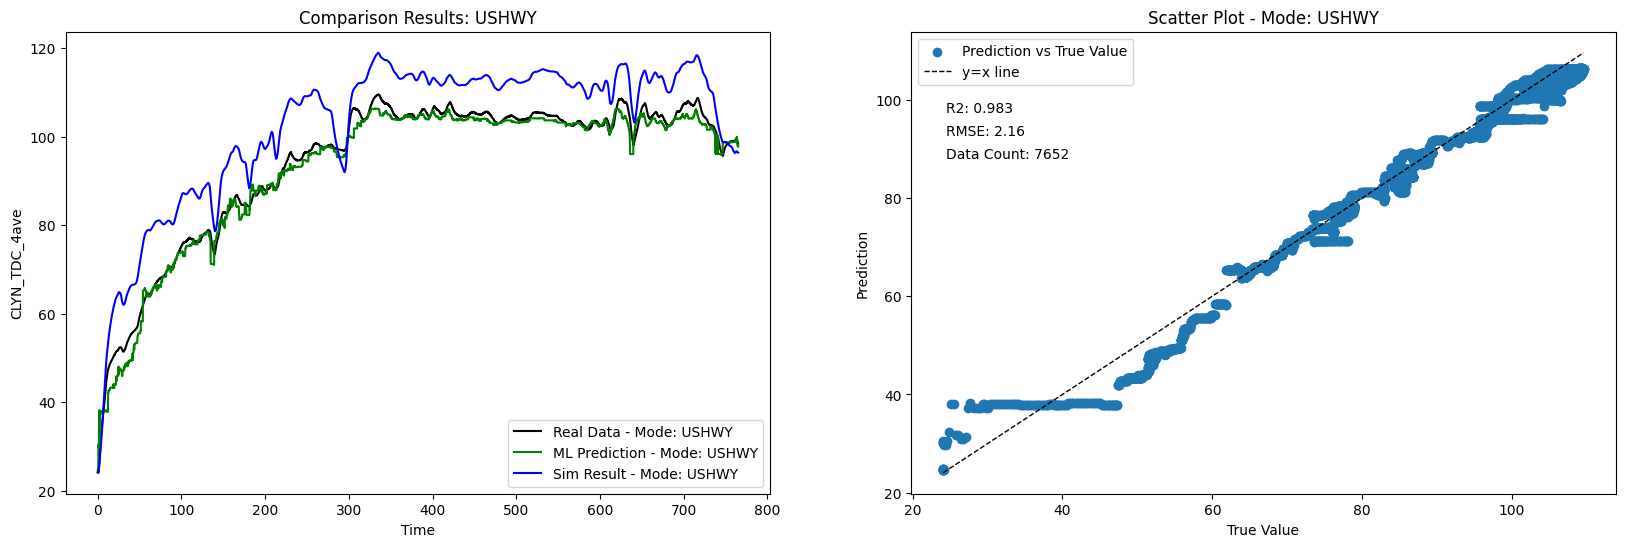

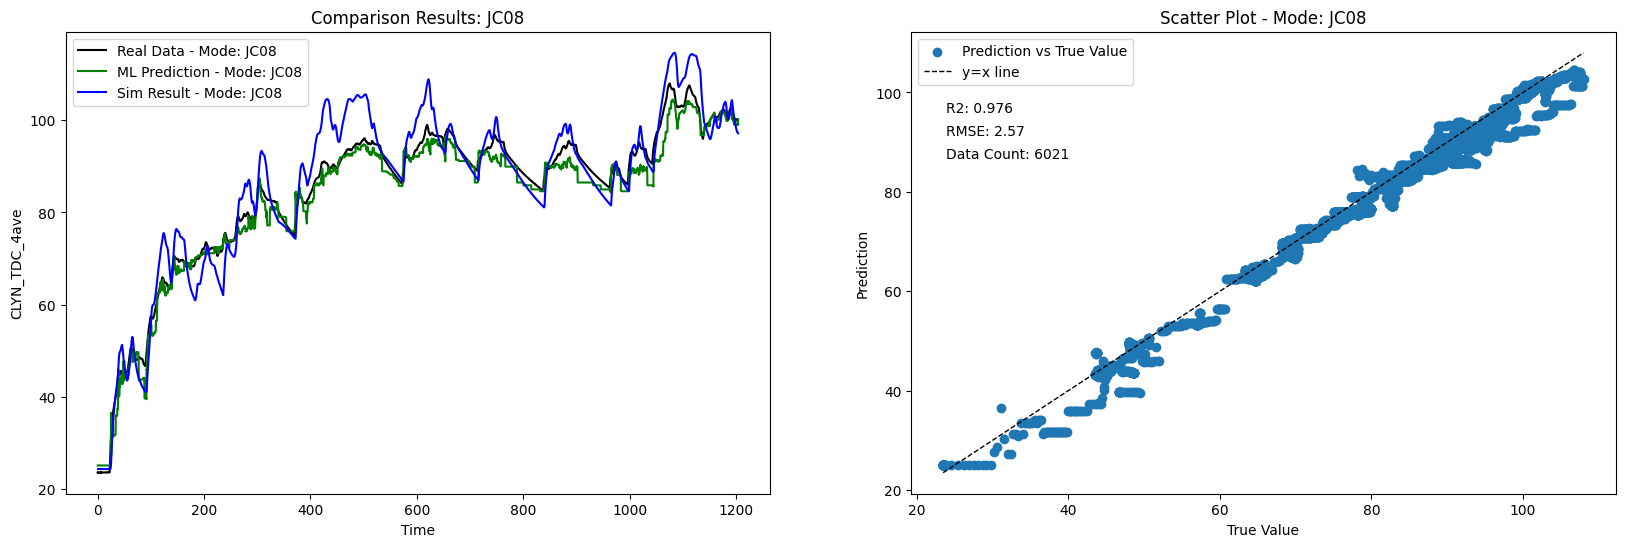

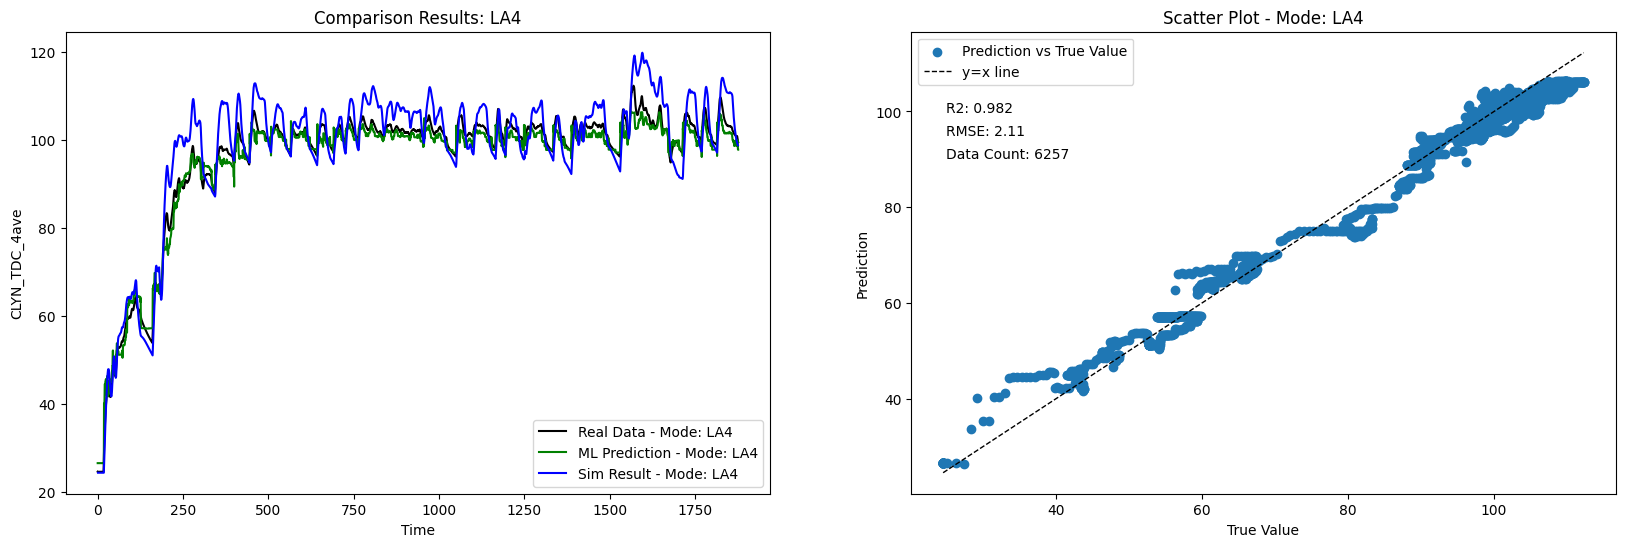

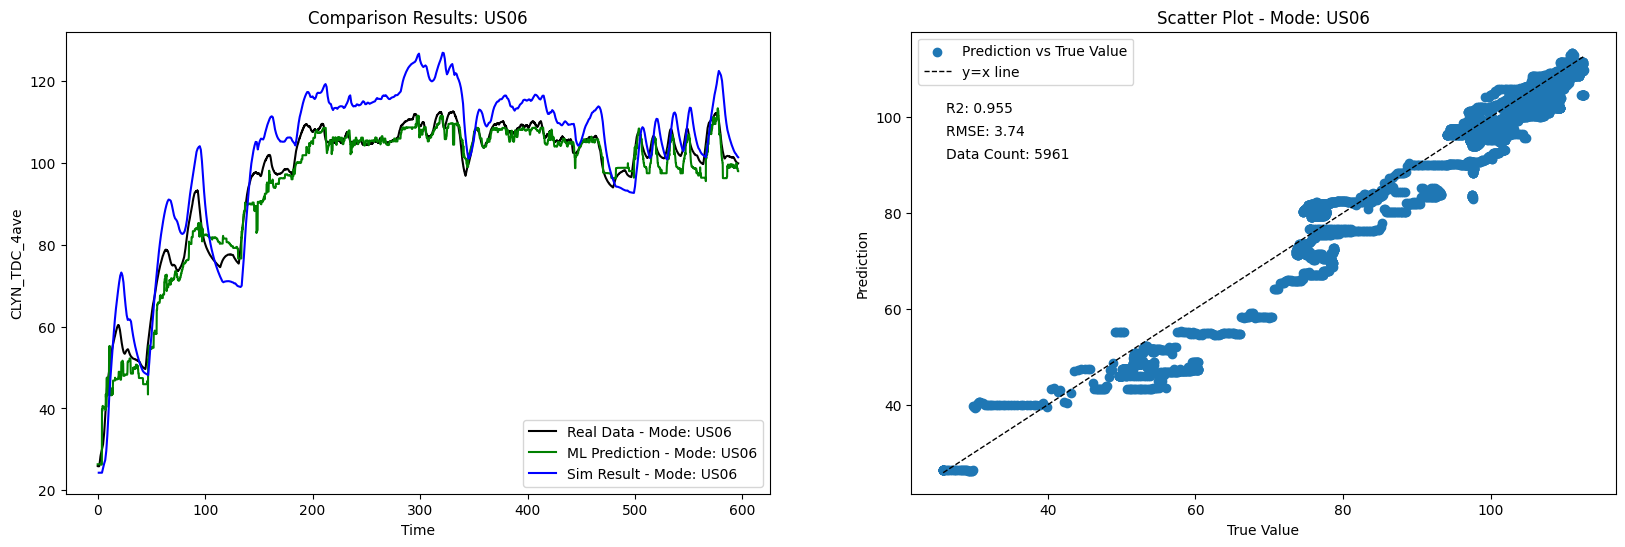

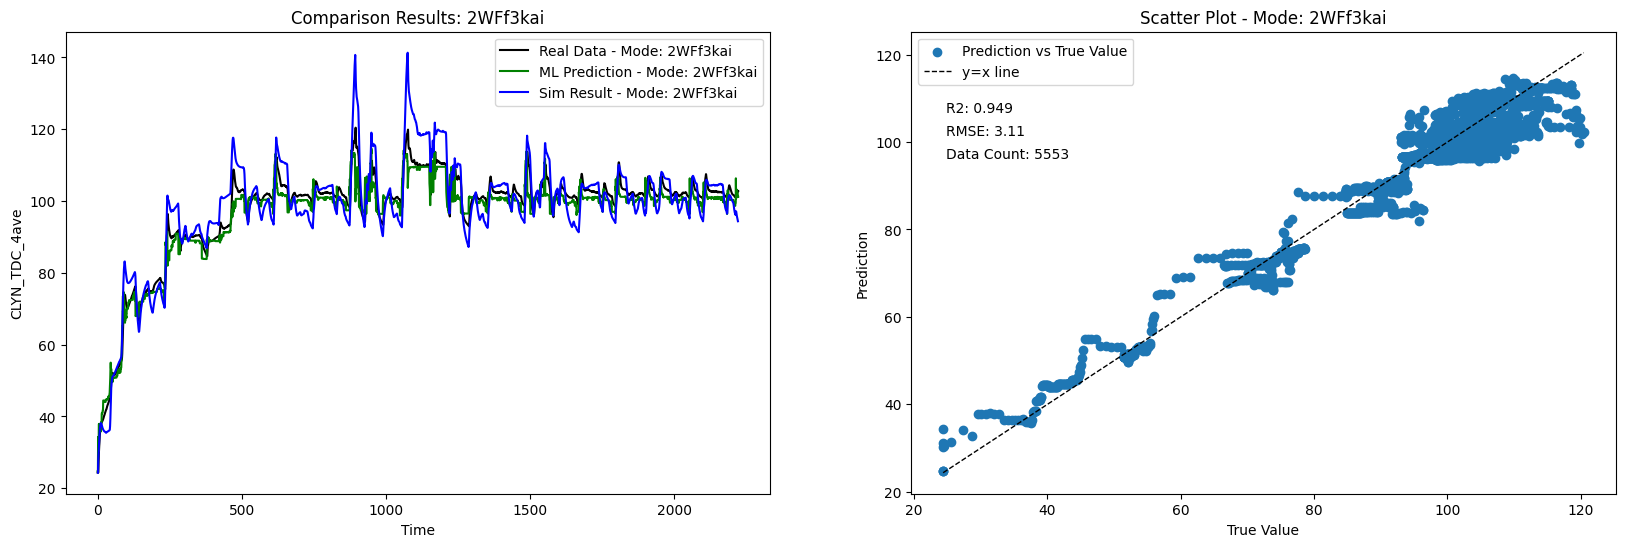

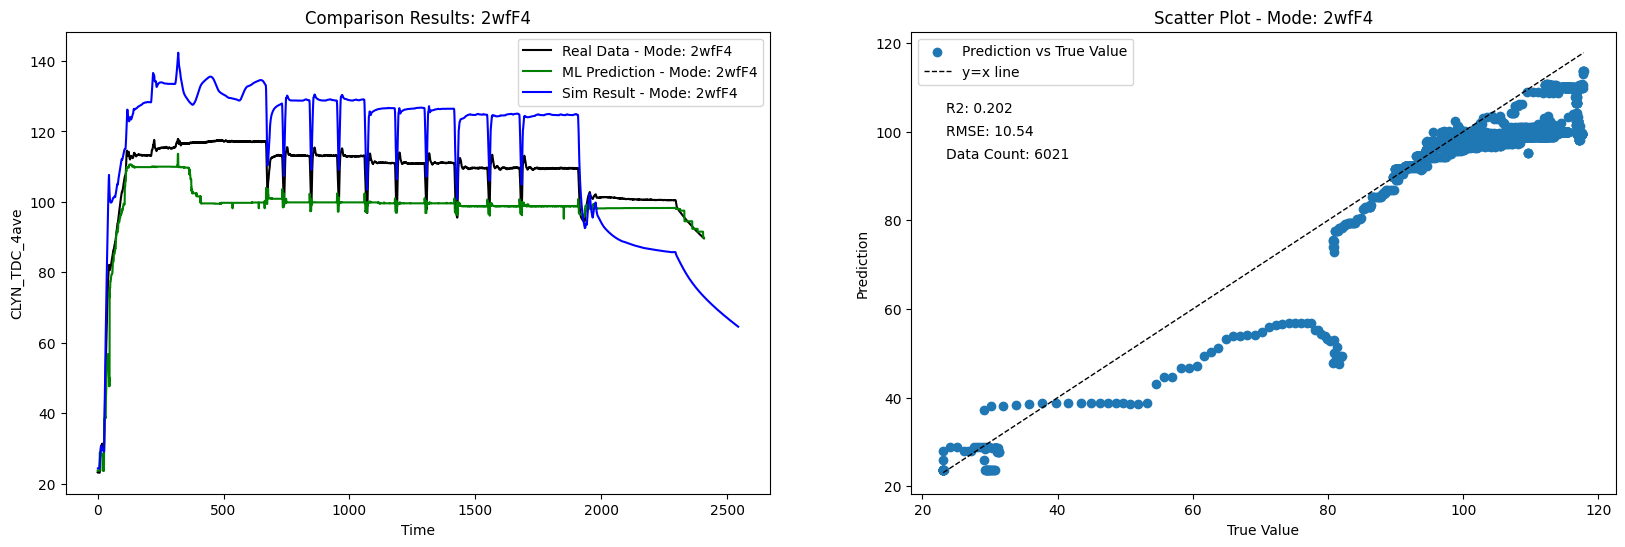

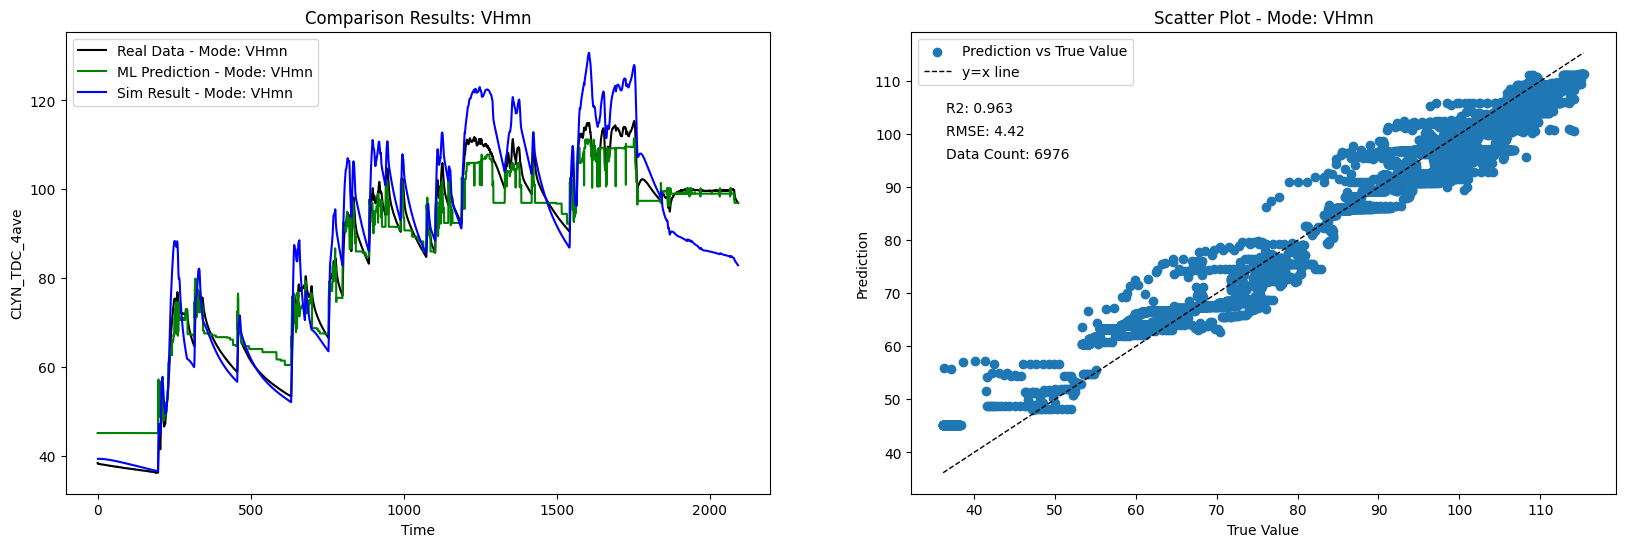

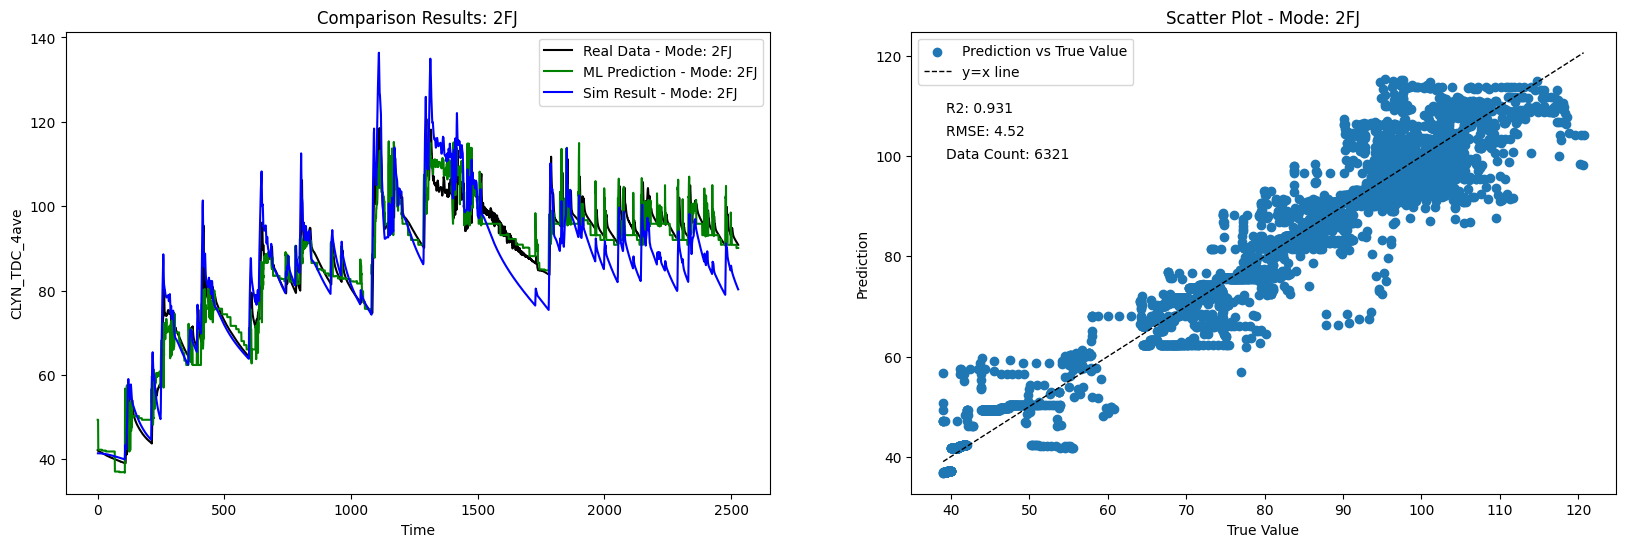

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import math

def plot_predictions(best_model, df, dfsim, feature_vars, target_variable, unique_modes):
    for test_mode in unique_modes:
        # 1行2列 subplot
        fig, axs = plt.subplots(1, 2, figsize=(20, 6))
        
        # Data divide
        train_df = df[df['Mode'] != test_mode]
        test_df = df[df['Mode'] == test_mode]
        
        # training
        X_train = train_df[feature_vars]
        y_train = train_df[target_variable]
        best_model.fit(X_train, y_train)

        # Predict
        X_test = test_df[feature_vars]
        y_test = test_df[target_variable]
        y_pred = best_model.predict(X_test)
        
        # Sim data
        filtered_dfsim = dfsim[dfsim['Mode'] == test_mode]
        sim_time_data = filtered_dfsim["time"]
        sim_target = filtered_dfsim[target_variable]
        
        # Time series plot
        axs[0].plot(test_df['time'], y_test, label=f'Real Data - Mode: {test_mode}', color='black')
        axs[0].plot(test_df['time'], y_pred, label=f'ML Prediction - Mode: {test_mode}', color='green')
        axs[0].plot(sim_time_data, sim_target, label=f'Sim Result - Mode: {test_mode}', color='blue')
        
        axs[0].set_xlabel('Time')
        axs[0].set_ylabel(target_variable)
        axs[0].set_title(f"Comparison Results: {test_mode}")
        axs[0].legend()
        
        # Evaluate
        r2_val = r2_score(y_test, y_pred)
        rmse_val = math.sqrt(mean_squared_error(y_test, y_pred))
        data_count = len(y_test)
        
        # Scatter Plot
        axs[1].scatter(y_test, y_pred, label=f'Prediction vs True Value')
        axs[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, label='y=x line')
        axs[1].set_xlabel('True Value')
        axs[1].set_ylabel('Prediction')
        axs[1].set_title(f'Scatter Plot - Mode: {test_mode}')
        axs[1].legend()
        axs[1].text(0.05, 0.85, f'R2: {r2_val:.3f}', transform=axs[1].transAxes, verticalalignment='top')
        axs[1].text(0.05, 0.80, f'RMSE: {rmse_val:.2f}', transform=axs[1].transAxes, verticalalignment='top')
        axs[1].text(0.05, 0.75, f'Data Count: {data_count}', transform=axs[1].transAxes, verticalalignment='top')
        
        plt.show()

plot_predictions(best_model, df, dfsim, feature_vars, target_variable, unique_modes)
